In [17]:
import sys
import glob
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.cm as cm
from scipy.interpolate import griddata
from scipy.io import savemat

import geocat.viz.util as gvutil

sys.path.append('/glade/work/ndietrich/Supplementary_Functions/')
import HelperFunctions as hp # Kinda janky way to add these functions, should make it a package but lazy

In [18]:
#Read in files
folderpath_tgcm = '/glade/scratch/bdilorenzo/GDC/tiegcm_files/'
folderpath_sat = '/glade/scratch/bdilorenzo/GDC/orbit_files/'

sat_filepath = folderpath_sat + 'gdc_drm_ephem_g2_allphases.ncdf'

sat1_file = xr.open_dataset(sat_filepath)


In [19]:
# Time
time_epoch = sat1_file['time'].values.astype('int')

time = [dt.datetime.utcfromtimestamp(j) for j in time_epoch]

e_time = sat1_file['elapsed_time'].values

i_reg = np.where(e_time == 456)[0][0]
i_glo = np.where(e_time == 821)[0][0]

time_loc = time[0:i_reg] #Phase 1
time_reg = time[i_reg:i_glo] #Phase 2
time_glo = time[i_glo:] #Phase 3


t_h = np.array(dt.datetime(2013,3,18,0,0,0))
i_d = int(np.where(time_loc >= t_h)[0][0])

time_h = time_loc[0:i_d] #First hour of Phase 1
time_h_round = []

for t in time_h:
    if t.second >= 30:
        time_h_round.append(t.replace(second=0) + dt.timedelta(minutes=1))
    else:
        time_h_round.append(t.replace(second=0))

time_h_round = np.array(time_h_round)

i_h1 = 122


Text(0.5, 1.0, 'Orbital Paths for First Hour')

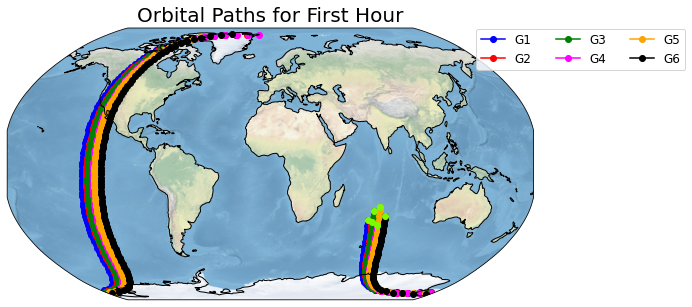

In [20]:
# Grab all satellite orbits and plot

satellites = [1,2,3,4,5,6]

sat_labels = ['G1','G2','G3','G4','G5','G6']
sat_colors = ['blue','red','green','magenta','orange','black']


Lat = np.zeros((6,len(e_time)))
Lon = np.zeros((6,len(e_time)))
Alt = np.zeros((6,len(e_time)))

c = 0
for s in satellites:
    satellite_filepath = folderpath_sat + 'gdc_drm_ephem_g' + str(s) + '_allphases.ncdf'
    satellite_file = xr.open_dataset(satellite_filepath)

    Lat[c,:] = satellite_file['geod_lat'].values
    Lon[c,:] = satellite_file['geod_lon'].values
    Alt[c,:] = satellite_file['geod_alt'].values

    c += 1


lat_loc = Lat[:,0:i_reg] #Phase 1
lon_loc = Lon[:,0:i_reg]

lat_reg = Lat[:,i_reg:i_glo] #Phase 2
lon_reg = Lon[:,i_reg:i_glo]

lat_glo = Lat[:,i_glo:] #Phase 3
lon_glo = Lon[:,i_glo:]

lat = lat_loc[:,0:i_h1] #Hour 1
lon = lon_loc[:,0:i_h1]
alt = Alt[:,0:i_h1]

lon = lon - 180

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.set_global()
ax.set_extent([180,-180,-90,90], ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()

for i in range(0,len(satellites)):
    ax.scatter(lon[i,:],lat[i,:],color = sat_colors[i],transform = ccrs.PlateCarree())
ax.scatter(lon[:,0],lat[:,0],color='lawngreen',transform=ccrs.PlateCarree())

legend_elements = [Line2D([0], [0], marker='o', color=sat_colors[s], label=sat_labels[s]) 
                    for s in range(0,len(satellites))]
plt.legend(handles=legend_elements,fontsize='large',bbox_to_anchor =(1.3, 1.02),ncol=3)
plt.title('Orbital Paths for First Hour',fontsize=20)

# plt.savefig('satellite_orbits_hour1.png')



In [21]:
# TIEGCM Files
tt1 = dt.datetime(2013,3,17,0,1)
tt2 = dt.datetime(2013,3,18,0,0)
timespan = np.arange(tt1, tt2, dt.timedelta(minutes=1)).astype(dt.datetime)

# Select which variable to look at
vars = ['DEN','TN','UN','VN','O2','O1','NE','TE','OP']
# total density, neutral temp, neutral zonal wind, neutral meridional wind, molecular oxygen,...
# atomic oxygen, electron density, electron temp, o+ ion
a = 1


tgcm_filepath = folderpath_tgcm + '13Ma_sech_tie_2013-03-17T00-01-00_2013-03-17T01-00-00.nc'
sat_filepath = folderpath_sat + 'gdc_drm_ephem_g1_allphases.ncdf'

tgcm_file = xr.open_dataset(tgcm_filepath)


var = tgcm_file[vars[a]].values
Lat_T = tgcm_file['lat'].values
Lon_T = tgcm_file['lon'].values
# ilev = tgcm_file['ilev'].values
ZG = tgcm_file['ZG'].values *(1e-5) #km


In [22]:

print(time_h[0:10])

time_h_check = pd.date_range(time_h[0], time_h[-1], periods=len(time_h)).to_pydatetime()
# count = 1;
# for j in range(0,len(time_h[0:10])):
#     if j == 0:
#         continue
#     elif (time_h[j] - time_h[j-1]).total_seconds() == 0:
#         count = count + 1
#     elif (time_h[j] - time_h[j-1]).total_seconds() != 0:
#         time_h_check.append( pd.date_range(time_h[j-count], time_h[j], periods=count+1).to_pydatetime() )

        
print(time_h_check[0:10])

print(len(time_h))
print(len(time_h_check))


[datetime.datetime(2013, 3, 17, 0, 0), datetime.datetime(2013, 3, 17, 0, 0), datetime.datetime(2013, 3, 17, 0, 0), datetime.datetime(2013, 3, 17, 0, 2, 8), datetime.datetime(2013, 3, 17, 0, 2, 8), datetime.datetime(2013, 3, 17, 0, 2, 8), datetime.datetime(2013, 3, 17, 0, 2, 8), datetime.datetime(2013, 3, 17, 0, 4, 16), datetime.datetime(2013, 3, 17, 0, 4, 16), datetime.datetime(2013, 3, 17, 0, 4, 16)]
[datetime.datetime(2013, 3, 17, 0, 0)
 datetime.datetime(2013, 3, 17, 0, 0, 29, 986791)
 datetime.datetime(2013, 3, 17, 0, 0, 59, 973583)
 datetime.datetime(2013, 3, 17, 0, 1, 29, 960375)
 datetime.datetime(2013, 3, 17, 0, 1, 59, 947167)
 datetime.datetime(2013, 3, 17, 0, 2, 29, 933958)
 datetime.datetime(2013, 3, 17, 0, 2, 59, 920750)
 datetime.datetime(2013, 3, 17, 0, 3, 29, 907542)
 datetime.datetime(2013, 3, 17, 0, 3, 59, 894334)
 datetime.datetime(2013, 3, 17, 0, 4, 29, 881126)]
2878
2878


In [23]:
# Take given satellite alt,lat,lon and map to TIEGCM ZG, gives ilev/lev for the given alt,lat,lon that is desired


LAT_model, LON_model = np.meshgrid( Lat_T, Lon_T, indexing='ij')

v_intp_all = np.zeros( lat.shape )


for s in range(0,len(satellites)):
    for i in range(0,lat.shape[1]):

        sat_lat = lat[s,i]
        sat_lon = lon[s,i]
        sat_alt = alt[s,i]

        idx_lat_r = np.searchsorted(Lat_T, sat_lat, side='Right')
        idx_lat_l = np.searchsorted(Lat_T, sat_lat, side='Right') - 1

        idx_lon_r = np.searchsorted(Lon_T, sat_lon, side='Right')
        idx_lon_l = np.searchsorted(Lon_T, sat_lon, side='Right') - 1


        LON_model_p1 = LON_model[idx_lat_r, idx_lon_r]
        LAT_model_p1 = LAT_model[idx_lat_r, idx_lon_r]

        LON_model_p2 = LON_model[idx_lat_r, idx_lon_l]
        LAT_model_p2 = LAT_model[idx_lat_r, idx_lon_l]

        LON_model_p3 = LON_model[idx_lat_l, idx_lon_r]
        LAT_model_p3 = LAT_model[idx_lat_l, idx_lon_r]

        LON_model_p4 = LON_model[idx_lat_l, idx_lon_l]
        LAT_model_p4 = LAT_model[idx_lat_l, idx_lon_l]


        #Map TIEGCM time to satellite orbit time
        if time_h_round[i] == tt1 - dt.timedelta(minutes=1):
            index = np.where(timespan >= time_h_round[i])[0][0]
        else:
            index = np.where(timespan == time_h_round[i])[0][0]
        

        alts_model_p1 = np.squeeze( ZG[index,:,idx_lat_r, idx_lon_r] )
        alts_model_p2 = np.squeeze( ZG[index,:,idx_lat_r, idx_lon_l] )
        alts_model_p3 = np.squeeze( ZG[index,:,idx_lat_l, idx_lon_r] )
        alts_model_p4 = np.squeeze( ZG[index,:,idx_lat_l, idx_lon_l] )
        alts_model = np.concatenate( (alts_model_p1, 
                                        alts_model_p2,
                                        alts_model_p3,
                                        alts_model_p4), axis=0)


        v_model_p1 = np.squeeze( var[index,:,idx_lat_r, idx_lon_r] )
        v_model_p2 = np.squeeze( var[index,:,idx_lat_r, idx_lon_l] )
        v_model_p3 = np.squeeze( var[index,:,idx_lat_l, idx_lon_r] )
        v_model_p4 = np.squeeze( var[index,:,idx_lat_l, idx_lon_l] )
        v_model = np.concatenate( (v_model_p1, 
                                    v_model_p2,
                                    v_model_p3,
                                    v_model_p4), axis=0)



        lons_model_p1 = np.ones( v_model_p1.shape ) * LON_model_p1
        lons_model_p2 = np.ones( v_model_p2.shape ) * LON_model_p2
        lons_model_p3 = np.ones( v_model_p3.shape ) * LON_model_p3
        lons_model_p4 = np.ones( v_model_p4.shape ) * LON_model_p4
        # glons_model = np.concatenate( (glons_model_p1,
        #                                glons_model_p2,
        #                                glons_model_p3,
        #                                glons_model_p4), axis=0)        
        lons_model = np.array( [LON_model_p1,
                                    LON_model_p2,
                                    LON_model_p3,
                                    LON_model_p4] )

        lats_model_p1 = np.ones( v_model_p1.shape ) * LAT_model_p1
        lats_model_p2 = np.ones( v_model_p2.shape ) * LAT_model_p2
        lats_model_p3 = np.ones( v_model_p3.shape ) * LAT_model_p3
        lats_model_p4 = np.ones( v_model_p4.shape ) * LAT_model_p4
        # glats_model = np.concatenate( (glats_model_p1,
        #                                glats_model_p2,
        #                                glats_model_p3,
        #                                glats_model_p4), axis=0)
        lats_model = np.array( [LAT_model_p1,
                                    LAT_model_p2,
                                    LAT_model_p3,
                                    LAT_model_p4] )

        # step 1 interpolations @ the same altitude
        v_intp_p1 = griddata( (alts_model_p1), v_model_p1,
                                (sat_alt), 
                                method='linear')
        v_intp_p2 = griddata( (alts_model_p2), v_model_p2,
                                (sat_alt), 
                                method='linear')
        v_intp_p3 = griddata( (alts_model_p3), v_model_p3,
                                (sat_alt), 
                                method='linear')
        v_intp_p4 = griddata( (alts_model_p4), v_model_p4,
                                (sat_alt), 
                                method='linear')

        # step 2 interpolations @ the lon, lat plane
        v_model = np.array( [v_intp_p1,
                                v_intp_p2,
                                v_intp_p3,
                                v_intp_p4] )
        v_intp_step2 = griddata( (lons_model, lats_model), v_model,
                                        (sat_lon, sat_lat ), 
                                            method='linear')

        v_intp_all[s,i] = v_intp_step2

# Next step is adjust script to account for all the different parameters that need to be sampled
# After that, adjust the script to read in all the TIEGCM files (1 days worth)



/glade/u/home/bdilorenzo/anaconda3/envs/NOAA/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: DeprecationWarning: inexact matches and case insensitive matches for search side are deprecated, please use one of 'left' or 'right' instead.
  return bound(*args, **kwds)
/glade/u/home/bdilorenzo/anaconda3/envs/NOAA/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: DeprecationWarning: inexact matches and case insensitive matches for search side are deprecated, please use one of 'left' or 'right' instead.
  return bound(*args, **kwds)
/glade/u/home/bdilorenzo/anaconda3/envs/NOAA/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: DeprecationWarning: inexact matches and case insensitive matches for search side are deprecated, please use one of 'left' or 'right' instead.
  return bound(*args, **kwds)
/glade/u/home/bdilorenzo/anaconda3/envs/NOAA/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: DeprecationWarning: inexact matches and case insensitive matches for

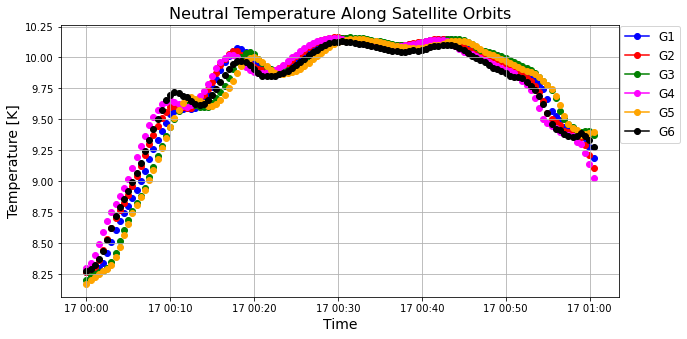

In [24]:
# Plotting

plt.figure(figsize=(10, 5))
for s in range(len(satellites)):
    plt.scatter(time_h_check[0:i_h1],v_intp_all[s,:]/100,color = sat_colors[s])
plt.title('Neutral Temperature Along Satellite Orbits', fontsize=16)
plt.ylabel('Temperature [K]', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.legend(handles=legend_elements,fontsize='large',bbox_to_anchor =(1.12, 1.02),ncol=1)
plt.grid()

# plt.savefig(vars[a] + '_GDC_hour1.png')
plt.show()




Text(0.5, 1.0, 'Orbital Paths for First Hour')

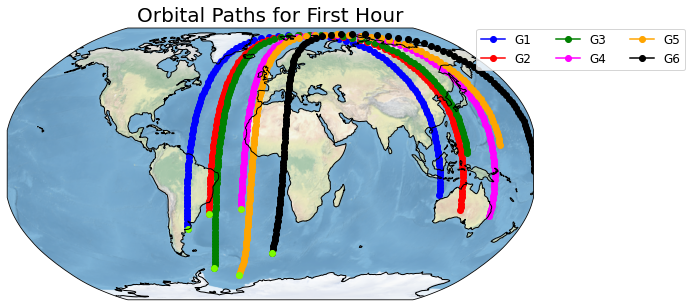

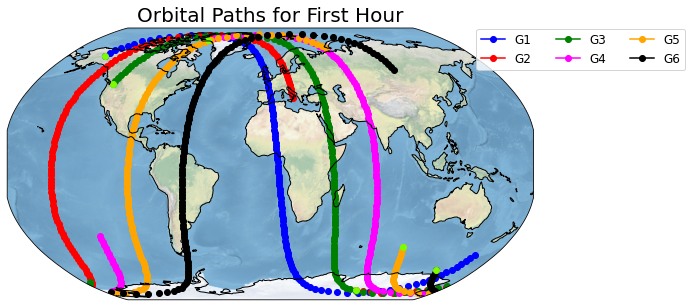

In [25]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.set_global()
ax.set_extent([180,-180,-90,90], ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()

for i in range(0,len(satellites)):
    ax.scatter(lon_reg[i,0:i_h1],lat_reg[i,0:i_h1],color = sat_colors[i],transform = ccrs.PlateCarree())
ax.scatter(lon_reg[:,0],lat_reg[:,0],color='lawngreen',transform=ccrs.PlateCarree())

legend_elements = [Line2D([0], [0], marker='o', color=sat_colors[s], label=sat_labels[s]) 
                    for s in range(0,len(satellites))]
plt.legend(handles=legend_elements,fontsize='large',bbox_to_anchor =(1.3, 1.02),ncol=3)
plt.title('Orbital Paths for First Hour',fontsize=20)


fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.set_global()
ax.set_extent([180,-180,-90,90], ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()

for i in range(0,len(satellites)):
    ax.scatter(lon_glo[i,0:i_h1],lat_glo[i,0:i_h1],color = sat_colors[i],transform = ccrs.PlateCarree())
ax.scatter(lon_glo[:,0],lat_glo[:,0],color='lawngreen',transform=ccrs.PlateCarree())

legend_elements = [Line2D([0], [0], marker='o', color=sat_colors[s], label=sat_labels[s]) 
                    for s in range(0,len(satellites))]
plt.legend(handles=legend_elements,fontsize='large',bbox_to_anchor =(1.3, 1.02),ncol=3)
plt.title('Orbital Paths for First Hour',fontsize=20)